In [5]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
from plots import *
from mf_sgd import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


number of items: 10000, number of users: 1000


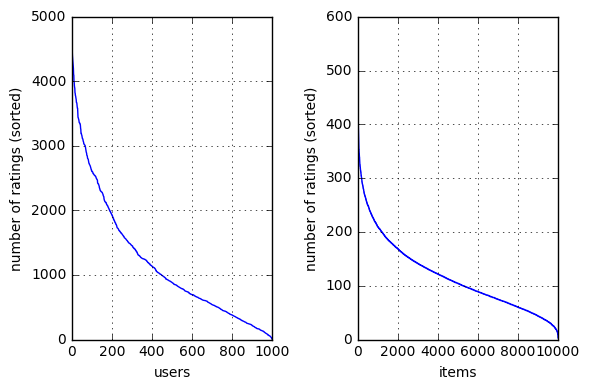

In [6]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

# Find the best values of the hyper-parameters

## Lambdas user

In [ ]:
lambdas_user = np.array([0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3])[:,np.newaxis]
lambda_item = 0

num_features = 20

k_fold = 4
num_epochs = 20
gamma = 0.01
filename = "mf_cv_lambda_user.png"

# Run cross-validation to find the best value of lambda user. The output is a plot of RMSE vs lambda
run_mf_cv_lambda_user(valid_ratings, k_fold, num_epochs, num_features, lambdas_user, lambda_item, filename)


## Lambdas item

In [ ]:
lambdas_item = np.array([0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3])[:,np.newaxis]
lambda_user = 0

num_features = 20

k_fold = 4
num_epochs = 20
gamma = 0.01
filename = "mf_cv_lambda_item.png"

# Run cross-validation to find the best value of lambda item. The output is a plot of RMSE vs lambda
run_mf_cv_lambda_item(valid_ratings, k_fold, num_epochs, num_features, lambda_user, lambdas_item, filename)


## Find The best "number of features"

In [ ]:
lambda_item = 0
lambda_user = 0

num_features = np.arange(10,250,30)

k_fold = 4
num_epochs = 20
gamma = 0.01
filename = "mf_cv_num_features.png"

# Run cross-validation to find the best value of lambda item. The output is a plot of RMSE vs lambda
run_mf_cv_num_features(ratings, k_fold, num_epochs, num_features, lambda_user, lambda_item, filename)

K-fold, iteration: 0
Num features: 10
learn the matrix factorization using SGD...


## Lambdas user and item

In [ ]:
from mf_sgd import *
from plots import *

num_epochs = 10 
gamma = 0.01

lambdas = np.array([0.0001, 0.01, 0.05, 0.1, 0.5])[:,np.newaxis]

lambdas_user = np.repeat(lambdas, len(lambdas))[:,np.newaxis]
lambdas_item = np.kron(np.ones((len(lambdas),1)), lambdas)

num_experiments = len(lambdas_user)
rmse_train = np.zeros((num_experiments, 1))
rmse_test = np.zeros((num_experiments, 1))

num_features = 30

for i in range(0, len(lambdas_user)):
    print('MF SGD started for lambdas(user,item) = (%s,%s)' % (str(lambdas_user[i]),str(lambdas_item[i])))
    rmse_train[i], rmse_test[i] = mf_sgd(train, test, num_epochs, gamma, num_features, lambdas_user[i], lambdas_item[i])


In [ ]:
rmse_visualization_vs_lambdas(lambdas_user, lambdas_item, rmse_train, rmse_test, "rmse_vs_lambdas.png")


## Compute X_pred = W*Z using the best values of the hyper-parameters

In [ ]:
"""matrix factorization by SGD."""

data = ratings

# define parameters
gamma = 0.01
num_features = 20   # K in the lecture notes
lambda_user = 0.1
lambda_item = 0.7
num_epochs = 2     # number of full passes through the train set

errors = [0]

# set seed
np.random.seed(988)

# init matrix
Z_opt, W_opt = init_MF(data, num_features)

# find the non-zero ratings indices 
nz_row, nz_col = data.nonzero()
nz_data = list(zip(nz_row, nz_col))

print("learn the matrix factorization using SGD...")
for it in range(num_epochs):        
    # shuffle the rating indices
    np.random.shuffle(nz_data)
    
    # decrease step size
    gamma /= 1.2

    for d, n in nz_data:
        e = train[d,n] - prediction(W[:,d],Z[:,n])
        Z_opt[:,n] += gamma * (e*W_opt[:,d] - lambda_item*Z_opt[:,n])
        W_opt[:,d] += gamma * (e*Z_opt[:,n] - lambda_user*W_opt[:,d])

    nz_row, nz_col = data.nonzero()
    nz_data = list(zip(nz_row, nz_col))
    rmse = compute_error(data,Z_opt,W_opt, nz_data)
    print("iter: {}, RMSE on training set: {}.".format(it, rmse))

    errors.append(rmse)
    
X_pred = prediction(W_opt,Z_opt) # Shape is DxN (D items, N users)

Create submission file

In [ ]:
from collections import deque
import datetime
from helpers import *
now = datetime.datetime.now()
now_str = now.strftime("%d-%m-%Y_%Hh%M_%S")
output_path = '../data/predictions-%s-group-clm.csv' % now_str

indices = extract_indices('../data/sampleSubmission.csv')

ratings_to_write = deque()
for row, col in indices:
    ratings_to_write.append((row, col, X_pred[row,col]))
    
create_csv_submission(ratings_to_write, output_path)
